In [158]:
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict
import re
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [159]:

# Function Definitions
def queryit(cursor, query): 
    cursor.execute(query)
    return cursor.fetchall()

def calculate_frequency(models_per_task):
    frequency_data = {}
    for task, timestamps in models_per_task.items():
        frequency = {}
        for timestamp in timestamps:
            year_month = timestamp[:7]  # Extract Year-Month
            frequency[year_month] = frequency.get(year_month, 0) + 1
        frequency_data[task] = frequency
    return frequency_data

def parse_single_file(url):
    response = requests.get(url)
    return response.content.decode("utf-8")

def extract_params(returned): 
    match = re.search(r'">(.*?) params<', returned)
    return match.group(1) if match else None

def replace_tag(row_dict, tag_to_domain): 
    for repo_url in row_dict:
        row_dict[repo_url]['domain.name'] = None
        for domain in tag_to_domain: 
            if row_dict[repo_url]['tag.name'] in tag_to_domain[domain]: 
                row_dict[repo_url]['domain.name'] = domain

def mil_bil(x):
    try:  
        if 'M' in x: 
            return 1000000 * float(re.sub('(M)', '', x))
        elif 'B' in x: 
            return 1000000000 * float(re.sub('(B)', '', x))
        else: 
            return 0
    except ValueError: 
        return 0 

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]

In [160]:
conn = sqlite3.connect('./PeaTMOSS.db')
cursor = conn.cursor()

In [290]:
hub_id = 2
query = f'''
    SELECT 
        model.id,
        GROUP_CONCAT(tag.name) AS tags
    FROM 
        model
    INNER JOIN model_to_tag ON model.id = model_to_tag.model_id
    INNER JOIN tag ON model_to_tag.tag_id = tag.id
    WHERE 
        model.model_hub_id = {hub_id}
    GROUP BY model.id
'''
rows_hub = queryit(cursor, query)

In [291]:
len(rows_hub)

362

In [292]:
domains = {
        'NLP': ['nlp'],
        'Computer Vision': ['generative', 'video', 'object_detection', 'segmentation', 'vision', 'optical_flow'],
        'Audio': ['audio'],
        'Multimodal': [],
        'Other': ['researchers', 'cuda-optional', 'cuda', 'quantization', 'scriptable']
    }

In [297]:
data = [(row[0], row[1]) for row in rows_hub]
data

[(1, 'vision,researchers,cuda'),
 (2, 'vision,researchers,cuda'),
 (3, 'vision,researchers,cuda'),
 (4, 'vision,researchers,cuda'),
 (5, 'vision,researchers,cuda'),
 (6, 'researchers,cuda,audio'),
 (7, 'vision,researchers,cuda'),
 (8, 'researchers,cuda,audio'),
 (9, 'vision,researchers,cuda'),
 (10, 'vision,researchers,cuda'),
 (11, 'vision,researchers,cuda'),
 (12, 'vision,researchers,cuda'),
 (13, 'vision,researchers,cuda'),
 (14, 'researchers,cuda,audio'),
 (15, 'researchers,cuda,audio'),
 (16, 'researchers,cuda,audio'),
 (17, 'researchers,cuda,audio'),
 (18, 'vision,researchers,cuda-optional'),
 (19, 'vision,researchers,cuda-optional'),
 (20, 'vision,researchers,cuda-optional'),
 (21, 'vision,researchers,cuda-optional'),
 (22, 'vision,researchers,cuda-optional'),
 (23, 'vision,researchers,cuda-optional'),
 (24, 'vision,researchers,cuda-optional'),
 (25, 'vision,researchers,cuda-optional'),
 (26, 'vision,researchers,cuda-optional,scriptable'),
 (27, 'vision,researchers,cuda-optional

In [294]:
store = {} 
for da in data: 
  if da[0] not in store: 
      store[da[0]] = []

  for domain_name, tasks in domains.items():
    for task in tasks:
      if task in da[1]:
        if domain_name not in store[da[0]]:
          store[da[0]].append(domain_name)

In [295]:
len(store)

362

In [308]:
# Iterate through the dictionary and update tags
for key, tag_list in store.items():
    # Filter out "Other" from the tag list
    filtered_tag_list = [tag for tag in tag_list if tag != "Other"]

    if len(filtered_tag_list) == 0:
        # If the list is empty after removing "Other", label it as "Other"
        store[key] = ["Other"]
    elif len(filtered_tag_list) >= 2:
        # If there are two or more tags after filtering, label it as "Multimodal"
        store[key] = ["Multimodal"]
    else:
        # If there is one tag after filtering, keep it as it is
        store[key] = filtered_tag_list


In [309]:
store

{1: ['Computer Vision'],
 2: ['Computer Vision'],
 3: ['Computer Vision'],
 4: ['Computer Vision'],
 5: ['Computer Vision'],
 6: ['Audio'],
 7: ['Computer Vision'],
 8: ['Audio'],
 9: ['Computer Vision'],
 10: ['Computer Vision'],
 11: ['Computer Vision'],
 12: ['Computer Vision'],
 13: ['Computer Vision'],
 14: ['Audio'],
 15: ['Audio'],
 16: ['Audio'],
 17: ['Audio'],
 18: ['Computer Vision'],
 19: ['Computer Vision'],
 20: ['Computer Vision'],
 21: ['Computer Vision'],
 22: ['Computer Vision'],
 23: ['Computer Vision'],
 24: ['Computer Vision'],
 25: ['Computer Vision'],
 26: ['Computer Vision'],
 27: ['Computer Vision'],
 28: ['Computer Vision'],
 29: ['Computer Vision'],
 30: ['Computer Vision'],
 31: ['Computer Vision'],
 32: ['Computer Vision'],
 33: ['Computer Vision'],
 34: ['Computer Vision'],
 35: ['Computer Vision'],
 36: ['Computer Vision'],
 37: ['Computer Vision'],
 38: ['Computer Vision'],
 39: ['Computer Vision'],
 40: ['Computer Vision'],
 41: ['Computer Vision'],
 42

In [310]:
tags = list(store.values())
tags

[['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Audio'],
 ['Computer Vision'],
 ['Audio'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Audio'],
 ['Audio'],
 ['Audio'],
 ['Audio'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['Computer Vision'],
 ['C

In [311]:
final_pytorch = {x: 0 for x in domains}
for tag in tags: 
  for domain in tag: 
    final_pytorch[domain] += 1

In [312]:
final_pytorch

{'NLP': 59, 'Computer Vision': 203, 'Audio': 100, 'Multimodal': 0, 'Other': 0}

In [352]:
# hub_id = 1
# query = f'''
#     SELECT 
#         model.id, tag.name
#     FROM 
#         model
#     INNER JOIN model_to_tag ON model.id = model_to_tag.model_id
#     INNER JOIN tag ON model_to_tag.tag_id = tag.id
#     WHERE 
#         model.model_hub_id = {hub_id}
#     GROUP BY model.id
# '''
# rows_hub = queryit(cursor, query)

hub_id = 1
query = '''
    
    SELECT 
        model.id,
        GROUP_CONCAT(tag.name) AS tags
    FROM 
        model
    INNER JOIN model_to_tag ON model.id = model_to_tag.model_id
    INNER JOIN tag ON model_to_tag.tag_id = tag.id
    WHERE 
        model.model_hub_id = 1
    GROUP BY model.id
'''
rows_hub = queryit(cursor, query)

In [353]:
rows_hub

[(363,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (364,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (365,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (366,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (367,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (368, 'summarization,co2_eq_emissions,autotrain,unk'),
 (391, 'stable-diffusion,text-to-image'),
 (395, 'text-classification,distilbert,model-index,generated_from_trainer'),
 (396, 'text-classification,xlm-roberta,model-index,generated_from_trainer'),
 (398, 'text-classification,generated_from_trainer,xlm-roberta'),
 (399,
  'autotrain_compatible,image-classification,model-index,generated_from_trainer,vit'),
 (400, 'autotrain_compatible,vit,image-classification'),
 (401,
  'autotrain_compatible,image-classification,model-index,generated_from_trainer,vit'),
 (407, 'text-gen

In [354]:
len(rows_hub)

167810

In [355]:
domains  = {
    'Multimodal': ['feature-extraction', 'text-to-image', 'image-to-text', 'text-to-video', 'visual-question-answering', 'graph-machine-learning'],
    'Computer Vision': ['depth-estimation', 'image-classification', 'object-detection', 'image-segmentation', 'image-to-image', 'unconditional-image-generation', 'video-classification', 'zero-shot-image-classification'],
    'NLP': ['text-classification', 'token-classification', 'table-question-answering', 'question-answering', 'zero-shot-classification', 'translation', 'summarization', 'conversational', 'text-generation', 'text2text-generation', 'fill-mask', 'sentence-similarity', 'table-to-text', 'multiple-choice', 'text-retrieval'],
    'Audio': ['text-to-speech', 'text-to-audio', 'automatic-speech-recognition', 'audio-to-audio', 'audio-classification', 'voice-activity-detection'],
    'Other': ['reinforcement-learning','robotics','tabular-classification','tabular-regression','tabular-to-text','time-series-forecasting']
}

In [356]:
data = [(row[0], row[1]) for row in rows_hub]
data

[(363,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (364,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (365,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (366,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (367,
  'autotrain_compatible,text-generation-inference,t5,text2text-generation'),
 (368, 'summarization,co2_eq_emissions,autotrain,unk'),
 (391, 'stable-diffusion,text-to-image'),
 (395, 'text-classification,distilbert,model-index,generated_from_trainer'),
 (396, 'text-classification,xlm-roberta,model-index,generated_from_trainer'),
 (398, 'text-classification,generated_from_trainer,xlm-roberta'),
 (399,
  'autotrain_compatible,image-classification,model-index,generated_from_trainer,vit'),
 (400, 'autotrain_compatible,vit,image-classification'),
 (401,
  'autotrain_compatible,image-classification,model-index,generated_from_trainer,vit'),
 (407, 'text-gen

In [357]:
data = [(row[0], row[1]) for row in rows_hub]

In [358]:
store = {} 
for da in data: 
  if da[0] not in store: 
      store[da[0]] = []

  for domain_name, tasks in domains.items():
    for task in tasks:
      if task in da[1]:
        if domain_name not in store[da[0]]:
          store[da[0]].append(domain_name)


In [359]:
# Iterate through the dictionary and update tags
for key, tag_list in store.items():
    if len(tag_list) >= 2:
        store[key] = ["Multimodal"]


In [363]:
tags = list(store.values())

In [364]:
final_hf = {x: 0 for x in domains}
for tag in tags: 
  for domain in tag:
    final_hf[domain] += 1

In [365]:
final_hf

{'Multimodal': 14496,
 'Computer Vision': 7234,
 'NLP': 94320,
 'Audio': 13946,
 'Other': 26340}

In [366]:
final_pytorch

{'NLP': 59, 'Computer Vision': 203, 'Audio': 100, 'Multimodal': 0, 'Other': 0}

In [367]:
total_hf = sum(final_hf.values())
total_pytorch = sum(final_pytorch.values())

total_hf, total_pytorch

(156336, 362)

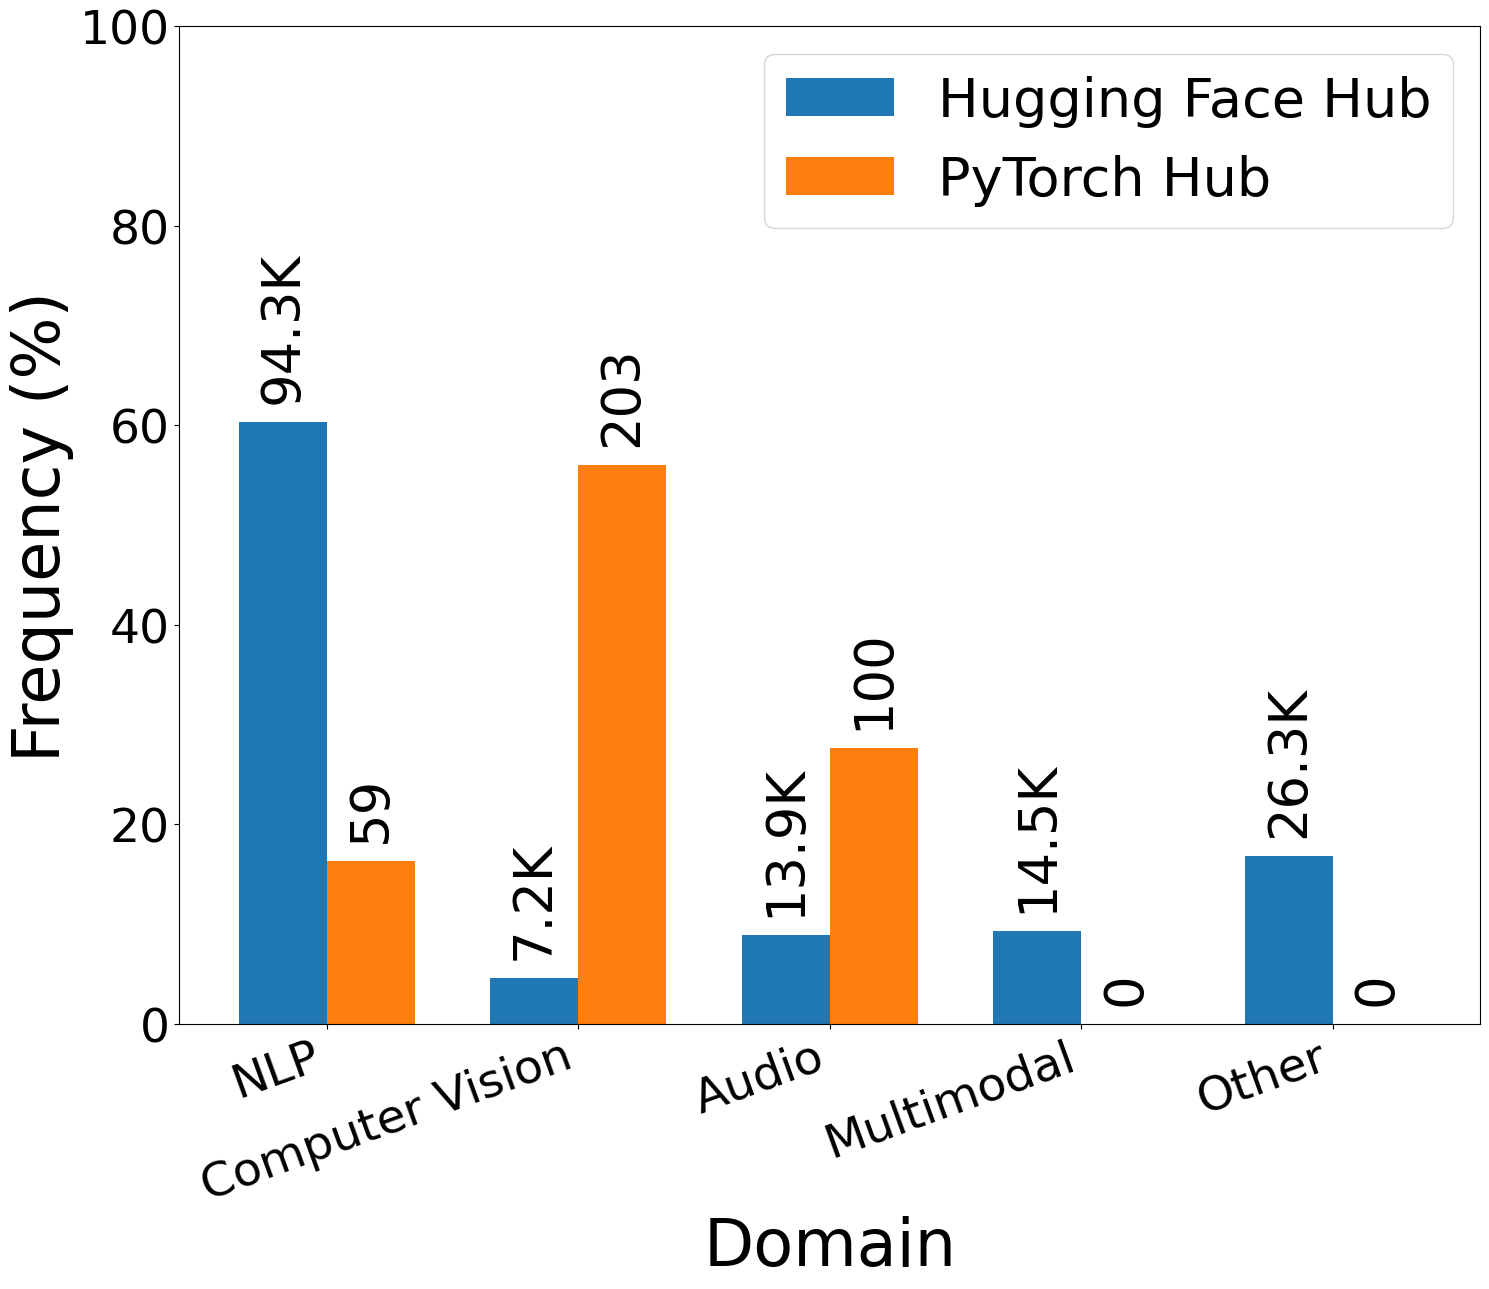

In [368]:
total1 = total_hf
total2 = total_pytorch


domain_counts_hub1 = {key: 100* (value / total1) for key, value in final_hf.items()}
rows1_hub1 = dict(sorted(domain_counts_hub1.items(), key=lambda item: item[1], reverse=True))
domain_counts_hub2 = {key: 100* (value / total2) for key, value in final_pytorch.items()}
rows1_hub2 = dict(sorted(domain_counts_hub2.items(), key=lambda item: item[1], reverse=True))

# Manually set the order of the tags
tags = ['NLP', 'Computer Vision', 'Audio', 'Multimodal', 'Other']

# Recalculate frequencies according to the new tags order
freq_hub1 = [rows1_hub1.get(tag, 0) for tag in tags]
freq_hub2 = [rows1_hub2.get(tag, 0) for tag in tags]

plt.figure(figsize=(15, 13))

# Plotting the bars with the new order
bar_width = 0.35
index = np.arange(len(tags))

plt.bar(index, freq_hub1, bar_width, alpha=1, label='Hugging Face Hub')
plt.bar(index + bar_width, freq_hub2, bar_width, alpha=1, label='PyTorch Hub')

# Adding data labels above the bars
for i, (fh1, fh2) in enumerate(zip(freq_hub1, freq_hub2)):
    text1 = total1 * (fh1 / 100)  # Removed division by 1000
    text2 = total2 * (fh2 / 100)  # Removed division by 1000

    # Format the label text
    text1_label = f'{text1/1000:.1f}K' if text1 >= 1000 else f'{round(text1)}'
    text2_label = f'{text2/1000:.1f}K' if text2 >= 1000 else f'{round(text2)}'

    # Place labels on the bars, slightly above the bar heights
    plt.text(i, fh1 + 3, text1_label, ha='center', fontsize=38, rotation=90)
    plt.text(i + bar_width, fh2 + 3, text2_label, ha='center', fontsize=38, rotation=90)


# Set the labels, ticks, legend, and fix the y-axis to 100%
plt.xlabel('Domain', fontsize=47)
plt.ylabel('Frequency (%)', fontsize=47)
plt.xticks(index + bar_width / 2, tags, rotation=20, fontsize=28, ha='right')
plt.yticks(fontsize=34)
plt.xticks(fontsize=34)
plt.legend(fontsize=39)
plt.ylim(0, 100)  # Set y-axis to go from 0 to 100%
plt.tight_layout()
plt.savefig('./fig8.pdf')
plt.show()

In [369]:
perc_hf = {}
# calcualte percentage of each values
for key, item in final_hf.items():
    perc_hf[key] = f"{item/total_hf * 100:.2f}%"
perc_hf

{'Multimodal': '9.27%',
 'Computer Vision': '4.63%',
 'NLP': '60.33%',
 'Audio': '8.92%',
 'Other': '16.85%'}

In [370]:
perc_pytorch = {}
# calcualte percentage of each values
for key, item in final_pytorch.items():
    perc_pytorch[key] = f"{item/total_pytorch * 100:.2f}%"
perc_pytorch

{'NLP': '16.30%',
 'Computer Vision': '56.08%',
 'Audio': '27.62%',
 'Multimodal': '0.00%',
 'Other': '0.00%'}